In [1]:
# adding scritps to path
import sys
sys.path.insert(1, '/mnt/c/Users/john/OneDrive - University of Toronto/software/sliding_twin')

In [2]:
# dependencies
import os
import pickle
import numpy as np
import scipy as sci
import pandas as pd
import nilearn as nil
import nibabel as nib
import scipy.io as sio
import slide_twin as twin # mine
from math import prod
from importlib import reload
from nilearn import plotting
from matplotlib.pyplot import plot
from scipy.signal import argrelextrema, find_peaks
from nilearn.input_data import NiftiLabelsMasker

/home/john/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [3]:
# reload modules
reload(twin)

<module 'slide_twin' from '/mnt/c/Users/john/OneDrive - University of Toronto/software/sliding_twin/slide_twin.py'>

# Gathering Time Windows

In [4]:
win=20
step=1

In [9]:
input_path = "/mnt/c/Users/john/OneDrive - University of Toronto/software/preprocessing/input.txt"
input_data = np.genfromtxt(input_path, delimiter=',', dtype=str)

In [6]:
atlas_img = "/mnt/c/Users/john/Desktop/craddock_2012/mni_t20__scorr05_2level_all.nii.gz"
atlas_nii = nib.load(atlas_img)
atlas_msk = atlas_nii.get_fdata()

In [11]:
for count, subj in enumerate(input_data, start=1):
    os.makedirs(os.path.join(subj, "sliding_timewindows"), exist_ok=True)

    nii_path = os.path.join(subj, "func", "s_scrub_nuis_nl_m_t_func.nii.gz")
    roi_path = os.path.join(subj, "sliding_timewindows", "roi_tcourses.csv")
    # twin_path= os.path.join(subj, "sliding_timewindows", "roi_twin.mat")
    twin_path= os.path.join(subj, "sliding_timewindows", "roi_twin.pkl")

    nii_img = nib.load(nii_path)
    nii_mat = nii_img.get_fdata()
    # masker = NiftiLabelsMasker(labels_img=atlas_mask, standardize=True)
    # tcourses= masker.fit_transform(nii_path)
    tcourses = twin.atlas_tcourse(nii_mat, atlas_msk, standardize=True)

    fc_mats, twindows = twin.sliding_twin(tcourses, win, step, twin_path)

    fc_var = np.asanyarray([np.nanvar(fc_mats[:,:,X]) for X in range(fc_mats.shape[2])])
    local_max = np.transpose(argrelextrema(fc_var, np.greater))

    lmax_path = os.path.join(subj, "sliding_timewindows", "var_localmax.csv")
    np.savetxt(lmax_path, local_max.astype(int), fmt='%i', delimiter=",")
    print(str(count), "/", str(len(input_data)))

1 / 50
2 / 50
3 / 50
4 / 50
5 / 50
6 / 50
7 / 50
8 / 50
9 / 50
10 / 50
11 / 50
12 / 50
13 / 50
14 / 50
15 / 50
16 / 50
17 / 50
18 / 50
19 / 50
20 / 50
21 / 50
22 / 50
23 / 50
24 / 50
25 / 50
26 / 50
27 / 50
28 / 50
29 / 50
30 / 50
31 / 50
32 / 50
33 / 50
34 / 50
35 / 50
36 / 50
37 / 50
38 / 50


/mnt/c/Users/john/OneDrive - University of Toronto/software/sliding_twin/slide_twin.py:34: RuntimeWarning: Mean of empty slice
  return np.nanmean(new, axis=0)


39 / 50
40 / 50
41 / 50
42 / 50
43 / 50
44 / 50
45 / 50
46 / 50
47 / 50
48 / 50
49 / 50
50 / 50


# Finding high-variance FC matrices across all partipants

In [65]:
subj_nan = []

In [66]:
for count, subj in enumerate(input_data, start=1):
    fc_path = os.path.join(subj, "sliding_timewindows", "roi_twin.pkl")
    fc_file = open(fc_path, "rb")
    fc_dict = pickle.load(fc_file)
    fc_mat  = fc_dict["fc_mats"]

    if (np.isnan(fc_mat)).any():
        subj_nan.append(os.path.basename(subj))
        print(subj)
        continue

    varpeak_path = os.path.join(subj, "sliding_timewindows", "var_localmax.csv")
    varpeak_ind  = np.genfromtxt(varpeak_path)
    varpeak_ind  = varpeak_ind.astype(int)

    fc_subsamp = fc_mat[:,:,varpeak_ind]

    if count==1:
        subsamp_coll = fc_subsamp
    else:
        subsamp_coll = np.append(subsamp_coll, fc_subsamp, axis=2)

/mnt/d/doctoral_thesis/Rest/2596ZL
/mnt/d/doctoral_thesis/Rest/2608ZL


In [67]:
# reshaping into 2D matrix
new_shape = [prod(subsamp_coll.shape[:2]), subsamp_coll.shape[2]]
fcmat_col = np.reshape(subsamp_coll, new_shape, order="F")
fcmat_col = np.transpose(fcmat_col)

In [68]:
fcmat_col = np.nan_to_num(fcmat_col, nan=0.0)

# K-Median Clustering

In [69]:
sys.path.insert(1, '/mnt/c/Users/john/OneDrive - University of Toronto/software/K_clustering')

In [70]:
from nilearn import plotting
from k_clustering import kmed, euc_dist, kmeans # mine

In [71]:
ss_ls = []

for kk in range(1,11):
    _, km_tmp = kmed(fcmat_col, k=kk, max_iter=500)
    ss_ls.append(km_tmp.inertia_)

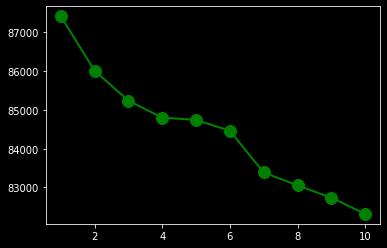

In [72]:
plot(range(1,11), ss_ls, "go-", linewidth=2, markersize=12)

In [73]:
y_kmeds, km = kmed(fcmat_col, k=7, max_iter=500)
# y_kmeds is the cluster membership
# km is the kmeans object. Centroids are stored in km.cluster_centers_
# SS_k is the sum of squares error

In [74]:
kcentroids = np.transpose(km.cluster_centers_)

In [75]:
orig_shape    = [199, 199, 7]
re_kcentroids = np.reshape(kcentroids, orig_shape, order="F")

## Plotting the Clusters

In [76]:
for ii in range(re_kcentroids.shape[2]):
    np.fill_diagonal(re_kcentroids[:,:,ii], 0)

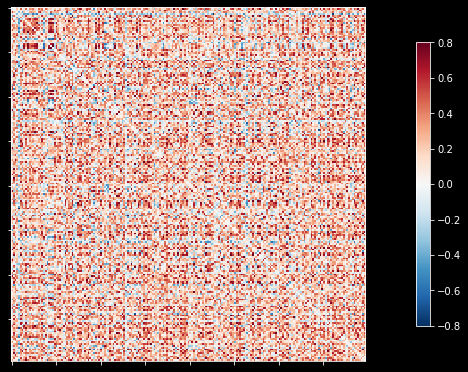

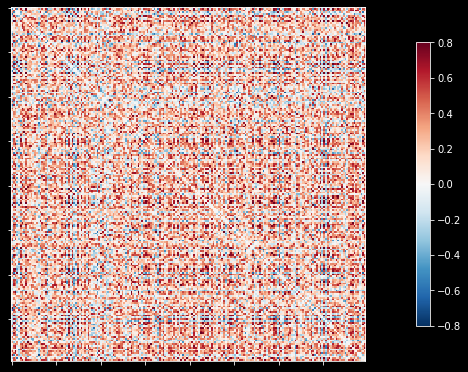

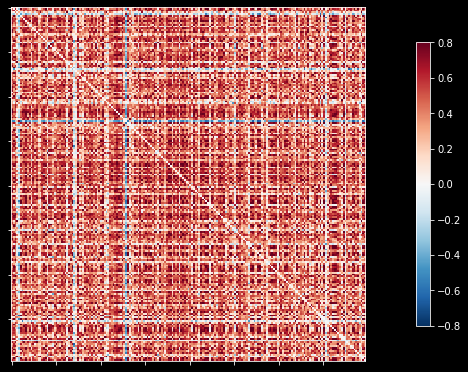

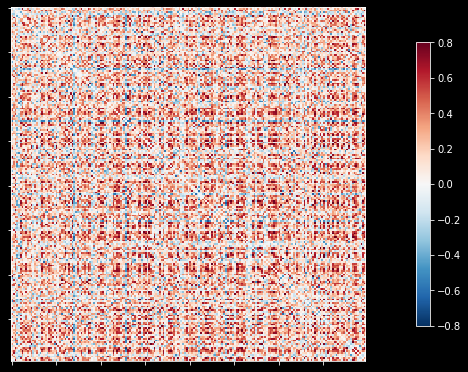

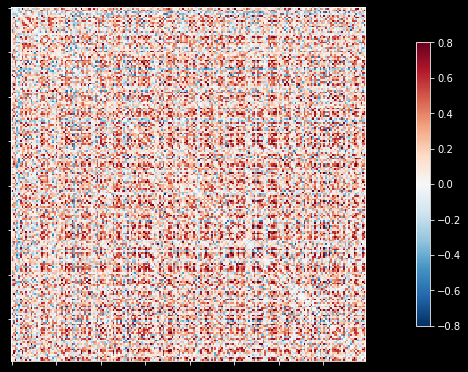

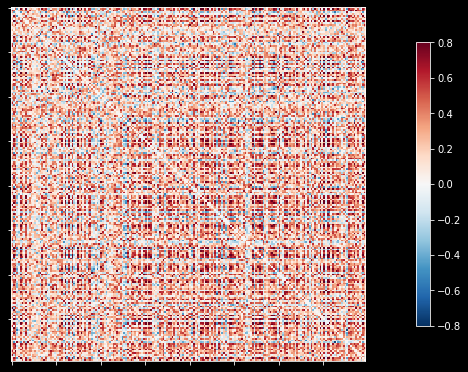

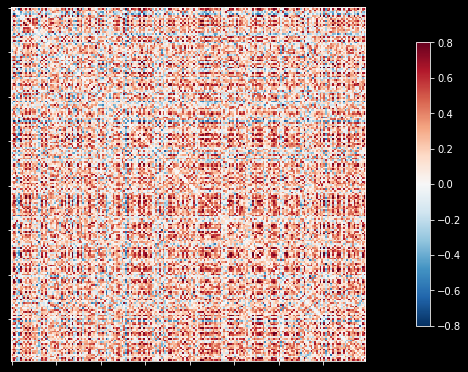

In [77]:
# TODO: Add labels to these.
for ii in range(re_kcentroids.shape[2]):
    plotting.plot_matrix(re_kcentroids[:,:,ii], colorbar=True, 
        vmax=.8, vmin=-.8)

## Plotting Connectomes

In [78]:
# importing atlas
atlas = nil.datasets.fetch_atlas_craddock_2012("craddock")

In [79]:
# fetch coordinates
# at = "/mnt/c/Users/john/OneDrive - University of Toronto/software/preprocessing/craddock/craddock_2012/scorr05_2level_all.nii.gz"
atlas_coords = plotting.find_parcellation_cut_coords(atlas_img) 

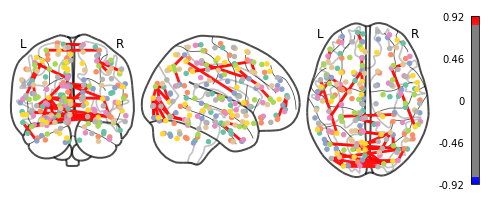

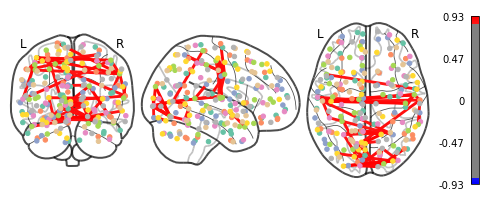

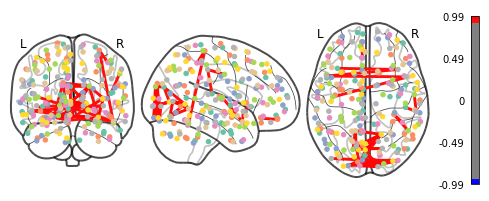

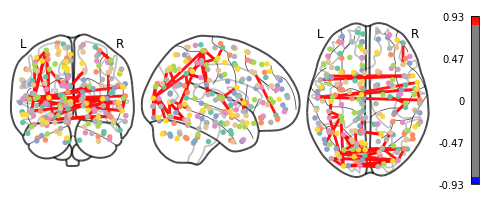

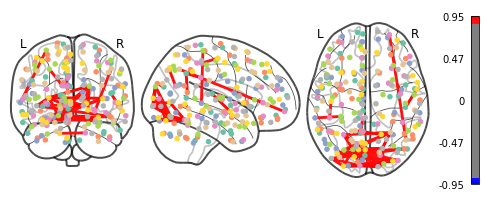

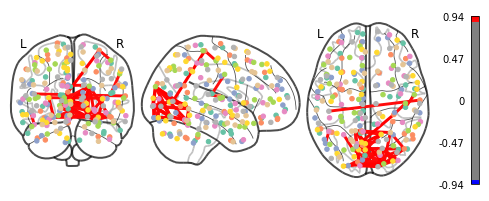

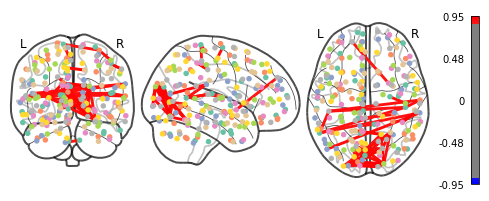

In [80]:
for ii in range(re_kcentroids.shape[2]):
    plotting.plot_connectome(re_kcentroids[:,:,ii], atlas_coords,
        edge_threshold="99.8%", colorbar=True, node_size=20)

    plotting.show()

# Classifying Participant Volumes into Brain States

# TODO: Remove the people who you excluded from the k-clusetering


In [81]:
basedir = "/mnt/d/doctoral_thesis/Rest"
subj_ls = np.genfromtxt("/mnt/d/doctoral_thesis/OSU_data/subjectlist.txt", dtype=str)
subj_ls = subj_ls[:50]

In [82]:
# removing outliers from the subj_ls
subj_ls = list(set(subj_ls) - set(subj_nan))

In [83]:
# initialize matrix for euclidian dist. of time windows from brain states & state membership
kk_distMat   = np.zeros((124, re_kcentroids.shape[2], len(subj_ls))) # 124 = n time windows
kk_memberMat = np.zeros((len(subj_ls), re_kcentroids.shape[2]))

for ss, subj in enumerate(subj_ls, start=0):
    if subj in subj_nan:
        continue
    subj_file = os.path.join(basedir, subj, "sliding_timewindows", "roi_twin.pkl")
    with open(subj_file, "rb") as file:
        subj_data = pickle.load(file)
    
    for kk in range(re_kcentroids.shape[2]):
        for tt in range(124):
            kk_distMat[tt,kk,ss] = euc_dist(subj_data["fc_mats"][:,:,tt], re_kcentroids[:,:,kk])
    
    for tt in range(124):
        _, idx = min((val, idx) for (idx, val) in enumerate(kk_distMat[tt, :, ss]))
        kk_memberMat[ss, idx] += 1      

# Correlating Brain State Membership with Behavioural Performance

## SART Accuracy

In [84]:
# create blank table
sart_acc = {
    "cols": ["go", "nogo"],
    "rows": subj_ls,
    "data": np.empty([len(subj_ls), 2])
}

In [85]:
# gather SART accuracy
for ss, subj in enumerate(subj_ls, start=0):
    subj_dir  = os.path.join(basedir, subj, "behav", "sart_perf.csv")
    subj_data = pd.read_csv(subj_dir)
    sart_acc["data"][ss,0] = subj_data["mean.ACC.go"][0]
    sart_acc["data"][ss,1] = subj_data["mean.ACC.nogo"][0]

In [86]:
# correlate it with frequency
sartXacc_correl = {
    "go": [],
    "nogo": []
}

for kk in range(re_kcentroids.shape[2]):
    sartXacc_correl["go"].append(sci.stats.pearsonr(sart_acc["data"][:,0], kk_memberMat[:,kk]))
    sartXacc_correl["nogo"].append(sci.stats.pearsonr(sart_acc["data"][:,1], kk_memberMat[:,kk]))

In [87]:
sartXacc_correl["go"] # maybe bill this as exploratory, since there are very few ommission errors

[(0.14564550158077283, 0.32327860505008216),
 (-0.15982794225588914, 0.27786587607953805),
 (0.0022026253559218403, 0.9881454779109651),
 (-0.03463966837873451, 0.8151909800185975),
 (0.21840246482130127, 0.13587739775549545),
 (0.00016650018573162104, 0.999103864873483),
 (-0.27383728260767937, 0.059650665204378055)]

In [88]:
sartXacc_correl["nogo"]

[(0.17616967561398106, 0.23100993649536988),
 (-0.23621341991322514, 0.10601610113559484),
 (0.10280079421436672, 0.4868696723820688),
 (-0.14681926248336202, 0.3193520638218636),
 (-0.05933340898026153, 0.6887209942569418),
 (-0.2309345366683246, 0.1142862634326955),
 (0.19553145019428697, 0.18290283901307097)]

# Testing with behavioural data

## Go-Nogo

In [89]:
behav_dir = "/mnt/d/doctoral_thesis/SART"

In [90]:
# make blank matrix for later averaging
gonogo_fc = np.empty((fc_mat.shape[0], fc_mat.shape[0], len(subj_ls)))

In [91]:
for count, subj in enumerate(subj_ls):
    fc_path = os.path.join(behav_dir, subj, "fcmat", "fcmat.csv")
    fc_mat  = np.genfromtxt(fc_path, delimiter=",")

    gonogo_fc[:,:,count] = fc_mat

In [92]:
gonogo_fc = np.average(gonogo_fc,axis=2)

In [ ]:
gonogoFC_x_restFC = np.empty((re_kcentroids.shape[2], 2))

for kclus in range(re_kcentroids.shape[2]):
    x = np.reshape(re_kcentroids[:,:,kclus], )
    gonogoFC_x_restFC[kclus,:] = sci.stats.pearsonr(re_kcentroids[:,:,kclus], gonogo_fc)

In [100]:
sci.stats.pearsonr(re_kcentroids[:,:,kclus], gonogo_fc)

TypeError: No loop matching the specified signature and casting was found for ufunc add

In [ ]:
prod(3,4)